In [1]:
# Standard library imports
import time
import concurrent.futures
from math import tanh, sqrt, fabs, erf as math_erf

# Third-party imports

# Numerical computations
import numpy as np
from numpy.polynomial import Chebyshev

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.widgets import Slider

# Interactive widgets
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider, Output, RadioButtons

# Scientific computing
from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.interpolate import UnivariateSpline, interp1d

# Performance enhancement
from numba import njit

# Workflow for Color Fringe Computation and Chromatic Correction
This document outlines the steps needed to simulate chromatic aberration effects, including data import, interpolation, interactive curve fitting, and analysis of color fringe width. The simulation takes into account the physics of chromatic aberration, sensor response, and overexposure effects.

## 1. Data Import

In [2]:
# -----------------------------------------------------------------------------
# Import Longitudinal Chromatic Aberration Data
# -----------------------------------------------------------------------------
# Input: 
#    - wavelengths_CHL: wavelengths from 400 to 700 nm (10 nm steps)
#    - defocus_values: 31 defocus values (µm) corresponding to each wavelength
#
# Process:
#    - Combine wavelengths and defocus values into a (31, 2) array
#
# Output:
#    - CHLzf85: a (31, 2) NumPy array with columns [wavelength, defocus value]
# -----------------------------------------------------------------------------

wavelengths_CHL = np.arange(400, 701, 10)
values_defocus = [
    285.0, 190.0, 118.0, 63.0, 22.0, -9.0, -31.0, -46.0, -56.0, -62.0,
    -64.0, -63.0, -60.0, -54.0, -48.0, -39.0, -30.0, -20.0, -9.0, 3.0,
    15.0, 28.0, 41.0, 54.0, 68.0, 82.0, 96.0, 111.0, 125.0, 139.0, 156.0
]

CHLzf85 = np.column_stack((wavelengths_CHL, values_defocus))
print("CHLzf85 shape:", CHLzf85.shape)

CHLzf85 shape: (31, 2)


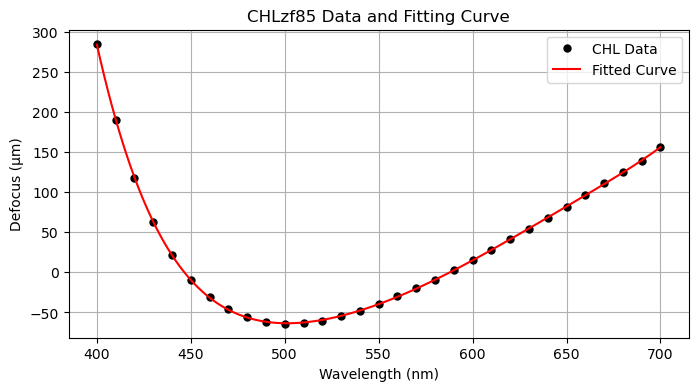

Fitted CHL coefficients: [ 6.17055255e-12 -2.17284405e-08  3.18690992e-05 -2.49424071e-02
  1.09994225e+01 -2.59404221e+03  2.55683162e+05]
CHL_fit shape: (300,)


In [3]:
# -----------------------------------------------------------------------------
# CHL Data Extraction and Fitting
# -----------------------------------------------------------------------------
# Input:
#    - CHLzf85: a (31, 2) NumPy array with columns [wavelength, defocus value]
#
# Process:
#    - Extract wavelength and defocus values.
#    - Fit a 6th-degree polynomial.
#    - Generate a smooth fitting curve (400-700 nm, 1 nm steps).
#
# Output:
#    - CHL_fit: fitted defocus values on a fine grid.
#
# Note:
#    - x_CHL: global sampling grid (400-700 nm, 10 nm steps)
#    - x_fit: global fitting grid (400-700 nm, 1 nm steps)
#    - CHLFit: a function for evaluating the polynomial fit.
# -----------------------------------------------------------------------------

x_CHL = CHLzf85[:, 0]
y_CHL = CHLzf85[:, 1]

CHL_coeffs = np.polyfit(x_CHL, y_CHL, 6)

def CHLFit(x):
    return np.polyval(CHL_coeffs, x)

x_fit = np.linspace(400, 700, 300)
CHL_fit = CHLFit(x_fit)

plt.figure(figsize=(8, 4))
plt.plot(x_CHL, y_CHL, 'o', markersize=5, color='black', label='CHL Data')
plt.plot(x_fit, CHL_fit, '-', color='red', label='Fitted Curve')
plt.title('CHLzf85 Data and Fitting Curve')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Defocus (µm)')
plt.legend()
plt.grid(True)
plt.show()

print("Fitted CHL coefficients:", CHL_coeffs)
print("CHL_fit shape:", CHL_fit.shape)

In [4]:
# -----------------------------------------------------------------------------
# Import Light Source Data
# -----------------------------------------------------------------------------
# Input: 
#    - wavelengths_daylight: wavelengths from 380 to 690 nm (10 nm steps)
#    - daylight_values: 32 intensity values corresponding to each wavelength
#
# Process:
#    - Combine wavelengths and intensity values into a (32, 2) array
#
# Output:
#    - Daylight_in: a (32, 2) NumPy array with columns [wavelength, intensity]
# -----------------------------------------------------------------------------

wavelengths_daylight = np.arange(380, 691, 10)
values_daylight = [
    11, 16, 22, 33, 48, 62, 71, 78, 84, 92,
    97, 100, 96, 95, 95, 94, 90, 78, 70, 78,
    88, 94, 91, 85, 82, 85, 92, 100, 89, 76,
    83, 100
]

Daylight_in = np.column_stack((wavelengths_daylight, values_daylight))
print("Daylight_in shape:", Daylight_in.shape)

Daylight_in shape: (32, 2)


In [5]:
# -----------------------------------------------------------------------------
# Import Sensor Response Data
# -----------------------------------------------------------------------------
# Input:
#    - wavelengths: wavelengths from 400 to 700 nm (10 nm steps)
#    - sensor_values: a dictionary containing three sensor channels(Blue, Green, Red),
#      each with 31 sensitivity values corresponding to the wavelengths.
#
# Process:
#    - For each sensor channel, combine wavelengths and sensitivity values into a (31, 2) NumPy array.
#
# Output:
#    - sensors: a dictionary where each key is a sensor channel name and each value is
#      a (31, 2) NumPy array with columns [wavelength, sensitivity].
# -----------------------------------------------------------------------------

wavelengths_sensor = np.arange(400, 701, 10)

values_sensor = {
    "SensorBlue": [
        0.42, 9.08, 24.34, 28.37, 40.12, 39.01, 47.12, 46.65, 41.14, 26.73,
        14.75, 7.55, 2.76, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.69, 0.84, 0.32, 0.04, 0.0
    ],
    "SensorGreen": [
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.63, 6.48, 9.09,
        17.75, 28.39, 37.8, 38.39, 35.02, 28.83, 28.1, 19.02, 13.1, 6.96,
        4.33, 3.34, 3.02, 0.0, 0.0, 0.0, 0.69, 0.7, 0.34, 0.05, 0.0
    ],
    "SensorRed": [
        0.0, 1.3, 1.86, 2.17, 1.73, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.38, 60.18, 100.0,
        92.73, 72.75, 50.6, 35.81, 35.08, 22.4, 16.96, 7.75, 3.3, 0.78, 0.18
    ]
}

# Create the dictionary with each sensor channel as a (31, 2) array
sensors_in = {name: np.column_stack((wavelengths_sensor, values))
           for name, values in values_sensor.items()}

# Extract the individual sensor arrays
SensorBlue = sensors_in["SensorBlue"]
SensorGreen = sensors_in["SensorGreen"]
SensorRed = sensors_in["SensorRed"]

# Optional: Display the shapes to verify they are (31, 2)
print("SensorBlue shape:", SensorBlue.shape)
print("SensorGreen shape:", SensorGreen.shape)
print("SensorRed shape:", SensorRed.shape)

SensorBlue shape: (31, 2)
SensorGreen shape: (31, 2)
SensorRed shape: (31, 2)


Resampled Daylight Spectrum: (31, 2)


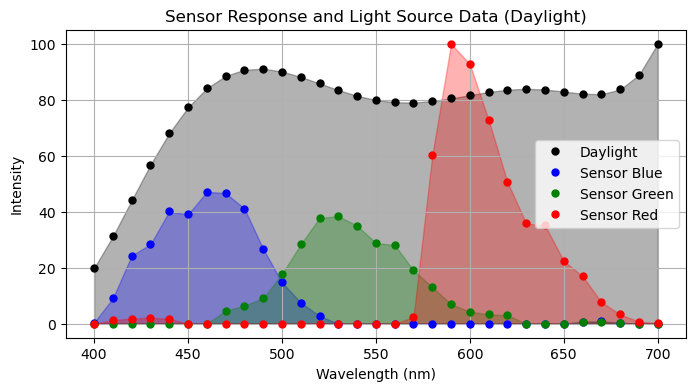

Sensor Blue normalized integral: 1.0
Sensor Green normalized integral: 1.0000000000000002
Sensor Red normalized integral: 1.0000000000000004


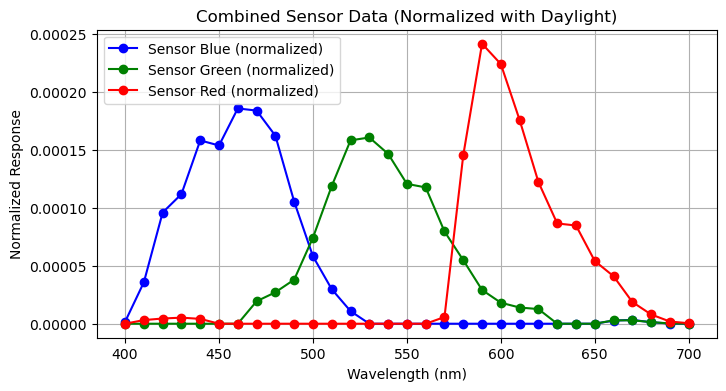

SensorBlue_norm shape: (31, 2)
SensorGreen_norm shape: (31, 2)
SensorRed_norm shape: (31, 2)


In [6]:
# -----------------------------------------------------------------------------
# Sensor Response and Daylight Spectrum Processing
# -----------------------------------------------------------------------------
# Input:
#    - Daylight_in: Daylight spectrum (NumPy array with columns [wavelength, intensity])
#    - x_CHL: Global wavelength grid (e.g., from CHL data)
#    - SensorBlue, SensorGreen, SensorRed: Sensor response arrays ([wavelength, intensity])
#
# Process:
#    - Resample Daylight_in via a 6th-degree polynomial fit and normalize (max = 100).
#    - Plot the resampled Daylight with the raw sensor responses.
#    - Compute normalization factors (via integration against daylight intensity)
#       and adjust each sensor so that ∫[Sensor * Daylight] dλ ≈ 1.
#    - Plot the normalized sensor responses.
#
# Output:
#    - Normalized sensor arrays: SensorBlue_norm, SensorGreen_norm, SensorRed_norm
# -----------------------------------------------------------------------------

def resample_spectrum_poly(spectrum, new_wavelengths, degree=6):
    """
    Resamples a given spectrum using a 6th-degree polynomial fit and normalizes its maximum to 100.
    """
    wavelengths, intensities = spectrum[:, 0], spectrum[:, 1]
    coeffs = np.polyfit(wavelengths, intensities, degree)
    new_intensities = np.poly1d(coeffs)(new_wavelengths)
    new_intensities = new_intensities / np.max(new_intensities) * 100
    return np.column_stack((new_wavelengths, new_intensities))

def plot_with_fill(x, y, color, marker='o', markersize=5, label=None):
    """
    Utility function to plot data points and fill under the curve.
    """
    plt.plot(x, y, marker, markersize=markersize, color=color, label=label)
    plt.fill_between(x, y, color=color, alpha=0.3)

def compute_norm(sensor, daylight_intensity, wavelengths):
    """
    Computes the normalization factor for a sensor such that the integral of the
    product of sensor response and daylight intensity is ~1.
    """
    sensor_response = sensor[:, 1]
    integral = np.trapezoid(sensor_response * daylight_intensity, x=wavelengths)
    norm_factor = 1 / integral if integral != 0 else 0
    return norm_factor, integral

# ======================== Part 1: Resample & Plot =============================
# Resample the Daylight spectrum
Daylight = resample_spectrum_poly(Daylight_in, x_CHL, degree=6)
print("Resampled Daylight Spectrum:", Daylight.shape)

plt.figure(figsize=(8, 4))
# Plot resampled Daylight spectrum
plot_with_fill(Daylight[:, 0], Daylight[:, 1], color='black', label='Daylight')

# Plot raw sensor responses using a dictionary for brevity
sensors = {
    "Sensor Blue": (SensorBlue, 'blue'),
    "Sensor Green": (SensorGreen, 'green'),
    "Sensor Red": (SensorRed, 'red')
}
for sensor_name, (sensor_data, color) in sensors.items():
    plot_with_fill(sensor_data[:, 0], sensor_data[:, 1], color=color, label=sensor_name)

plt.title('Sensor Response and Light Source Data (Daylight)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)
plt.show()

# =================== Part 2: Normalize & Plot Sensor Data (Concise with Correct Colors) =====================
daylight_intensity = Daylight[:, 1]

# Create a dictionary for storing normalized sensor arrays with their colors.
normSensors = {}

# Process each sensor: compute normalization factor, normalize data, and store with its color.
for sensor_name, (sensor_data, color) in sensors.items():
    norm_factor, _ = compute_norm(sensor_data, daylight_intensity, x_CHL)
    normalized_sensor = sensor_data.copy()
    normalized_sensor[:, 1] *= norm_factor
    normSensors[sensor_name] = (normalized_sensor, color)
    norm_integral = np.trapezoid(normalized_sensor[:, 1] * daylight_intensity, x=x_CHL)
    print(f"{sensor_name} normalized integral: {norm_integral}")

# Plot the normalized sensor responses, ensuring the correct color is used for each.
plt.figure(figsize=(8, 4))
for sensor_name, (normalized_sensor, color) in normSensors.items():
    plt.plot(x_CHL, normalized_sensor[:, 1], 'o-', color=color, label=f'{sensor_name} (normalized)')
plt.title('Combined Sensor Data (Normalized with Daylight)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Response')
plt.legend()
plt.grid(True)
plt.show()

# Final output: Extract and output the normalized sensor arrays.
SensorBlue_norm = normSensors["Sensor Blue"][0]
SensorGreen_norm = normSensors["Sensor Green"][0]
SensorRed_norm = normSensors["Sensor Red"][0]

print("SensorBlue_norm shape:", SensorBlue_norm.shape)
print("SensorGreen_norm shape:", SensorGreen_norm.shape)
print("SensorRed_norm shape:", SensorRed_norm.shape)

## 2. CHL Curve Modification and Visualization

In [7]:
# -----------------------------------------------------------------------------
# Modified CHL Curve Generation and Sampling
# -----------------------------------------------------------------------------
# This script demonstrates how to modify an existing CHL (defocus) curve by applying
# a horizontal shift and a tilt factor about a pivot point determined from the original
# curve. The modifications are made by adjusting the derivative of the CHL curve and then
# reconstructing the modified curve via numerical integration.
#
# Process:
#   - Pre-calculations: Determine the wavelength interval and the original minimum of the CHL curve.
#   - Interpolators: 
#         * A linear interpolator for the right section of the curve.
#         * A spline interpolator for the left section with zero smoothing.
#   - CHLFit_mod_overall: Computes the modified CHL curve with adjustable pivot shift and tilt.
#   - extract_sampled_modified_values_overall: Samples the modified curve at 10 nm intervals
#     between 400 nm and 700 nm, returning a two-column array (wavelength and floored CHL value)
# -----------------------------------------------------------------------------

# Pre-calculations and Setup
dx = x_fit[1] - x_fit[0]
min_idx = np.argmin(CHL_fit)
x_min, y_min = x_fit[min_idx], CHL_fit[min_idx]
print("Original lowest point at x = {:.2f} nm, y = {:.2f}".format(x_min, y_min))

linear_fit = interp1d(x_fit, CHL_fit, kind='linear', fill_value="extrapolate")
spline_fit = UnivariateSpline(x_fit, CHL_fit, s=0)

def CHLFit_mod_overall(x_vals, x_shift=0.0, tilt=0.0):
    """
    Apply a horizontal shift and tilt to modify the CHL curve.
    For x < pivot: derivative scaled by (1 - tilt)
    For x >= pivot: derivative scaled by (1 + tilt)
    
    Parameters:
        x_vals (array): Wavelength values.
        x_shift (float): Pivot shift.
        tilt (float): Tilt factor.
    
    Returns:
        np.ndarray: Modified CHL curve values.
    """
    # Determine the local spacing for the current x_vals
    local_dx = x_vals[1] - x_vals[0]
    
    pivot_x = x_min + x_shift  
    pivot_y = CHLFit(x_min)  # External CHL evaluation function
    x_shifted = x_vals - x_shift
    
    deriv_left = spline_fit.derivative()(x_shifted)
    deriv_right = np.gradient(linear_fit(x_shifted), local_dx)
    base_deriv = np.where(x_vals < pivot_x, deriv_left, deriv_right)
    new_deriv = np.where(x_vals < pivot_x, base_deriv * (1 - tilt), base_deriv * (1 + tilt))
    
    g = np.empty_like(x_vals)
    pivot_index = np.argmin(np.abs(x_vals - pivot_x))
    g[pivot_index] = pivot_y
    if pivot_index < len(x_vals) - 1:
        g[pivot_index + 1:] = pivot_y + np.cumsum(new_deriv[pivot_index:-1]) * local_dx
    if pivot_index > 0:
        g[:pivot_index] = pivot_y - np.cumsum(new_deriv[1:pivot_index + 1][::-1])[::-1] * local_dx
    
    return g

def extract_sampled_modified_values_overall(x_shift=0.0, tilt=0.0):
    """
    Sample the modified CHL curve every 10 nm from 400 nm to 700 nm.
    
    Returns:
        np.ndarray: Two-column array (wavelength, floored CHL value).
    """
    x_sample = np.arange(400, 701, 10)
    y_sample = CHLFit_mod_overall(x_sample, x_shift, tilt)
    return np.column_stack((x_sample, np.floor(y_sample)))

Original lowest point at x = 501.34 nm, y = -63.42


In [8]:
# -----------------------------------------------------------------------------
# Interactive CHL Curve Modification
# -----------------------------------------------------------------------------
# Input:
#    - CHL data: x_CHL, y_CHL (input CHL data points), x_fit, CHL_fit (fitting grid and values),
#      and an original evaluation function CHLFit.
#    - Functions: CHLFit_mod_overall and extract_sampled_modified_values_overall
#      (both defined externally) to modify and sample the CHL curve.
#
# Process:
#    - Compute a modified CHL curve by applying a horizontal shift (x_shift) and tilt to the original curve.
#    - Sample the modified curve using extract_sampled_modified_values_overall.
#    - Plot the modified CHL curve along with:
#         * The original CHL data (red),
#         * The original minimum (green),
#         * The shifted pivot (blue).
#
# Output:
#    - Global variable global_CHLfit: sampled, modified CHL array.
#    - An interactive plot that updates as x_shift and tilt are adjusted.
# -----------------------------------------------------------------------------

global_CHLfit = None  # Global variable to store the sampled modified CHL values

def get_modified_CHL_array(x_shift=0.0, tilt=0.0):
    """Update and return the global CHL array based on x_shift and tilt."""
    global global_CHLfit
    global_CHLfit = extract_sampled_modified_values_overall(x_shift, tilt)
    return global_CHLfit

def plot_CHL_overall(x_shift=0.0, tilt=0.0):
    """Plot the modified CHL curve along with original input data and key markers."""
    y_vals = CHLFit_mod_overall(x_fit, x_shift, tilt)
    plt.figure(figsize=(8, 4))
    plt.plot(x_fit, y_vals, lw=2, label='Modified CHL Curve')
    plt.scatter(x_CHL, y_CHL, color='red', label='Input CHL Data')
    plt.scatter([x_min], [y_min], color='green', s=100, label='Original Main Wavelength')
    plt.scatter([x_min + x_shift], [CHLFit(x_min)], color='blue', s=100, label='Shifted Main Wavelength')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Defocus (μm)')
    plt.title('Interactive Updated CHL Curve with Shift and Tilt')
    plt.legend()
    plt.grid(True)
    plt.xlim(400, 700)
    plt.ylim(-100, 700)
    plt.show()

# Setup interactive sliders for x_shift and tilt
x_shift_slider = FloatSlider(min=-80, max=80, step=1, value=0, description='x Shift (nm)')
tilt_slider = FloatSlider(min=-0.8, max=0.8, step=0.01, value=0, description='Tilt Factor')
out = Output()

def update_display(x_shift, tilt):
    """Update the plot and global CHL array when slider values change."""
    with out:
        out.clear_output(wait=True)
        plot_CHL_overall(x_shift, tilt)
        updated_array = get_modified_CHL_array(x_shift, tilt)
        print("Updated global_CHLfit array:")
        print(updated_array)

# Create and display the interactive interface.
interact(update_display, x_shift=x_shift_slider, tilt=tilt_slider)
display(out)

interactive(children=(FloatSlider(value=0.0, description='x Shift (nm)', max=80.0, min=-80.0, step=1.0), Float…

Output()

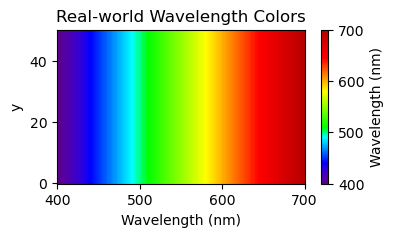

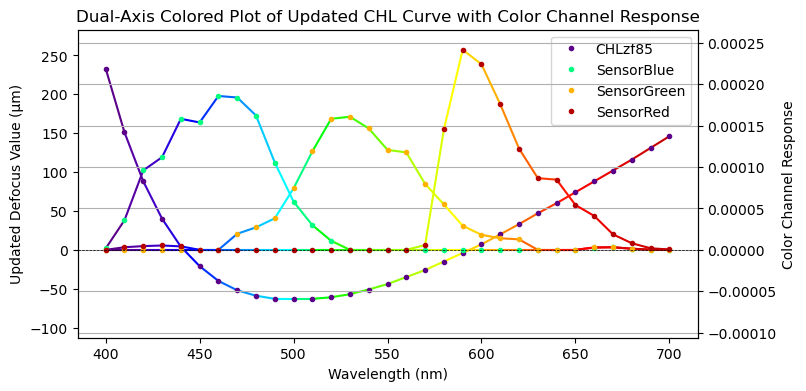

In [9]:
# --------------------------------------------------------------------
# Combined Plotting Script: Wavelength Density Plot and Dual-Axis Plot
# --------------------------------------------------------------------
# This script creates two plots:
#    - A density plot using a custom wavelength-based colormap (400–700 nm).
#    - A dual-axis plot overlaying global CHLfit data and sensor data.
#
# Input:
#    - global_CHLfit, x_fit
#    - SensorBlue_norm, SensorGreen_norm, SensorRed_norm
# --------------------------------------------------------------------

def wavelength_to_rgb(wavelength, gamma_cmap=1):
    """Convert wavelength (nm) to an approximate RGB value."""
    if 380 <= wavelength < 440:
        att = 0.3 + 0.7*(wavelength - 380)/60.0
        return (((440 - wavelength)/60.0 * att)**gamma_cmap, 0.0, (att)**gamma_cmap)
    elif 440 <= wavelength < 490:
        return (0.0, ((wavelength - 440)/50.0)**gamma_cmap, 1.0)
    elif 490 <= wavelength < 510:
        return (0.0, 1.0, ((510 - wavelength)/20.0)**gamma_cmap)
    elif 510 <= wavelength < 580:
        return (((wavelength - 510)/70.0)**gamma_cmap, 1.0, 0.0)
    elif 580 <= wavelength < 645:
        return (1.0, ((645 - wavelength)/65.0)**gamma_cmap, 0.0)
    elif 645 <= wavelength <= 780:
        att = 0.3 + 0.7*(780 - wavelength)/135.0
        return ((att)**gamma_cmap, 0.0, 0.0)
    else:
        return (0.0, 0.0, 0.0)

# Create custom colormap from 400 to 700 nm using x_fit instead of wavelengths
colors = [wavelength_to_rgb(w) for w in x_fit]
cmap = mcolors.LinearSegmentedColormap.from_list("wavelength_cmap", colors)

# -------------------------------
# Density Plot using pcolormesh with Wavelength Colors
# -------------------------------
y_vals = np.linspace(0, 50, 100)
X, Y = np.meshgrid(x_fit, y_vals)
Z = X  # the x-coordinate (wavelength) as data
plt.figure(figsize=(4, 2))
plt.pcolormesh(X, Y, Z, shading='auto', cmap=cmap)
plt.colorbar(label='Wavelength (nm)')
plt.title('Real-world Wavelength Colors')
plt.xlabel('Wavelength (nm)')
plt.ylabel('y')
plt.show()

# -------------------------------
# Dual-Axis Plot: Global CHLfit and Sensor Data
# -------------------------------
def plot_gradient(ax, x, y, cmap):
    """Plot line segments between adjacent points colored by wavelength."""
    norm = plt.Normalize(400, 700)
    for j in range(len(x) - 1):
        ax.plot(x[j:j+2], y[j:j+2], color=cmap(norm(x[j])))

# Define global y-axis limits and margins.
global_min, global_max = -80, 250
margin = 0.1 * (global_max - global_min)
g_min, g_max = global_min - margin, global_max + margin
r = (0 - g_min) / (g_max - g_min)

# Compute sensor data limits.
sens_max = max(SensorBlue_norm[:, 1].max(),
               SensorGreen_norm[:, 1].max(),
               SensorRed_norm[:, 1].max())
sens_margin = 0.1 * sens_max
sens_max_new = sens_max + sens_margin
sens_min_new = - (r / (1 - r)) * sens_max_new

fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()
ax1.set_ylim(g_min, g_max)
ax2.set_ylim(sens_min_new, sens_max_new)

# Plot global CHLfit data.
plot_gradient(ax1, global_CHLfit[:, 0], global_CHLfit[:, 1], cmap)
ax1.plot(global_CHLfit[:, 0], global_CHLfit[:, 1], 'o', markersize=3, color=cmap(0), label='CHLzf85')

# Plot sensor data.
sensors = [SensorBlue_norm, SensorGreen_norm, SensorRed_norm]
sensor_names = ['SensorBlue', 'SensorGreen', 'SensorRed']
for i, (sensor, name) in enumerate(zip(sensors, sensor_names), start=1):
    plot_gradient(ax2, sensor[:, 0], sensor[:, 1], cmap)
    ax2.plot(sensor[:, 0], sensor[:, 1], 'o', markersize=3, color=cmap(i/3), label=name)

# Add horizontal reference lines, labels, and legends.
ax1.axhline(0, color='k', linewidth=0.5, linestyle='--')
ax2.axhline(0, color='k', linewidth=0.5, linestyle='--')
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Updated Defocus Value (μm)')
ax2.set_ylabel('Color Channel Response')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
plt.title('Dual-Axis Colored Plot of Updated CHL Curve with Color Channel Response')
plt.grid(True)
plt.show()

In [10]:
# --------------------------------------------------------------------
# Setup for Sensor Data Processing, Edge Functions & Grid Search
# --------------------------------------------------------------------
# Data Setup for Sensor Channels:
#   - Convert sensor data from the normalized sensor arrays to NumPy arrays
#     with float64 precision for accurate computations.
#
# Global Constants and Parameters:
#   - K: A constant used in sensor data processing or modeling.
#   - xrange_val: Range for x values in plots (e.g., visualization limits).
#   - defocusrange: Controls the defocus range during focus analysis.
#   - tol: Tolerance value for color width calculations.
#   - F_value: Parameter used in model fitting or sensor data processing.
#   - g_value: Parameter likely related to sensor processing or edge function computation.
# --------------------------------------------------------------------

# Data Setup for Sensor Channels
SensorBluedata = np.asarray(SensorBlue_norm[:, 1], dtype=np.float64)
SensorGreendata = np.asarray(SensorGreen_norm[:, 1], dtype=np.float64)
SensorReddata  = np.asarray(SensorRed_norm[:, 1], dtype=np.float64)

# Global Constants and Parameters
K = 1.4
xrange_val = 400
defocusrange = 1000
tol = 0.15
F_value = 8
gamma_value = 1

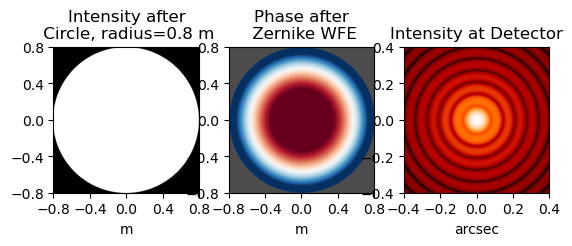

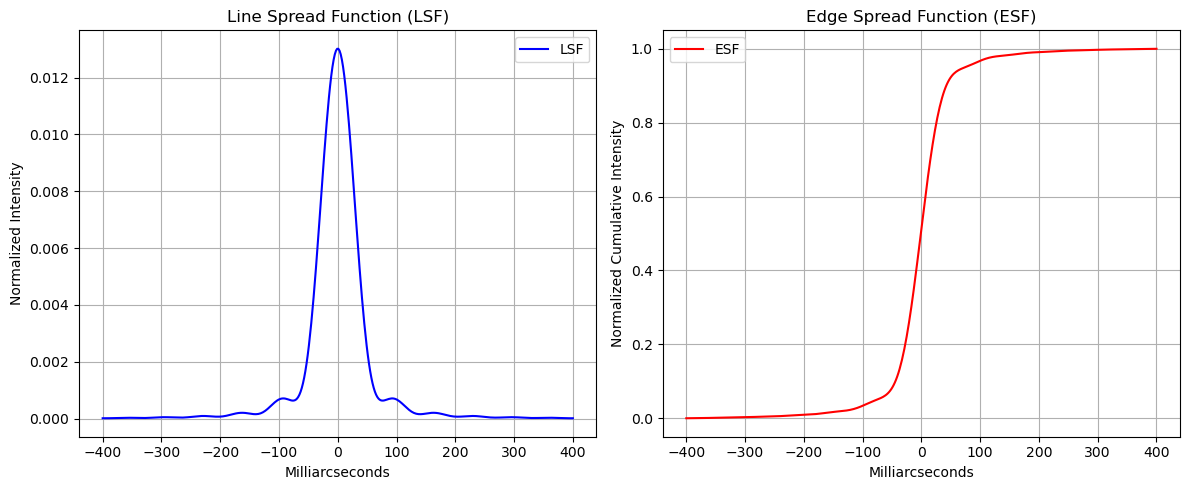

In [11]:
import poppy
import numpy as np
import matplotlib.pyplot as plt

# Calibration data:
global_CHLfit = np.array([
    [400, 233],
    [410, 151],
    [420, 88],
    [430, 40],
    [440, 4],
    [450, -21],
    [460, -40],
    [470, -52],
    [480, -59],
    [490, -63],
    [500, -63],
    [510, -63],
    [520, -61],
    [530, -57],
    [540, -51],
    [550, -44],
    [560, -35],
    [570, -26],
    [580, -15],
    [590, -4],
    [600, 7],
    [610, 20],
    [620, 33],
    [630, 47],
    [640, 60],
    [650, 74],
    [660, 88],
    [670, 102],
    [680, 116],
    [690, 131],
    [700, 146]
])

def compute_defocus_coefficient_from_calibration(wavelength_m, calibration_array):
    wavelength_nm = wavelength_m * 1e9
    indices = np.where(calibration_array[:, 0] == wavelength_nm)[0]
    if indices.size == 0:
        raise ValueError(f"Wavelength {wavelength_nm} nm not found in calibration data.")
    defocus_value_nm = calibration_array[indices[0], 1]
    defocus_value_m = defocus_value_nm * 1e-9
    # Compute and return the defocus coefficient using POPPY's normalization.
    # (1 unit corresponds to 2*sqrt(3) * wavelength wavefront error (PV)).
    return defocus_value_m / (2 * np.sqrt(3))

# ----------------------------------------------------------------------------
# Define optical system parameters.
xrange_val = 400               # Example value.
RADIUS = xrange_val / 500      # Aperture radius in meters.
PIXSCALE = 0.004               # Detector pixel scale in arcsec/pixel.
FOV = RADIUS                   # Field of view in arcsec (example value).

# Operating wavelength (in meters).
WAVELENGTH = 500e-9  # 500 nm

defocus_coefficient = compute_defocus_coefficient_from_calibration(WAVELENGTH, global_CHLfit)
coefficients_sequence = [0, 0, 0, defocus_coefficient]

# Set up the optical system
osys = poppy.OpticalSystem()
circular_aperture = poppy.CircularAperture(radius=RADIUS)
osys.add_pupil(circular_aperture)
zernikewfe = poppy.ZernikeWFE(radius=RADIUS, coefficients=coefficients_sequence)
osys.add_pupil(zernikewfe)
osys.add_detector(pixelscale=PIXSCALE, fov_arcsec=FOV)

def calculate_lsf(psf_data, fov_arcsec=1.0):
    # psf_data is expected to be a 2D numpy array
    ncols = psf_data.shape[1]
    # Convert FOV in arcsec to milliarcsec for the x-axis
    x_detector = np.linspace(-fov_arcsec/2 * 1e3, fov_arcsec/2 * 1e3, ncols)
    lsf = np.sum(psf_data, axis=0)
    lsf = lsf / np.trapezoid(lsf, x_detector)
    return x_detector, lsf

def calculate_esf(lsf):
    esf = np.cumsum(lsf)
    esf = (esf - esf[0]) / (esf[-1] - esf[0])
    return esf

# Calculate the PSF and extract its data array
psf_result = osys.calc_psf(wavelength=WAVELENGTH, display_intermediates=True)
psf_array = psf_result[0].data  # Extract the image data

# Calculate LSF and ESF from the PSF data
x_detector0, lsf0 = calculate_lsf(psf_array, fov_arcsec=FOV)
esf0 = calculate_esf(lsf0)

# Plot function
def plot_lsf_esf(x_detector, lsf, esf):
    plt.figure(figsize=(12, 5))
    
    # Plot the LSF.
    plt.subplot(1, 2, 1)
    plt.plot(x_detector, lsf, 'b-', label='LSF')
    plt.xlabel('Milliarcseconds')
    plt.ylabel('Normalized Intensity')
    plt.title('Line Spread Function (LSF)')
    plt.legend()
    plt.grid(True)
    
    # Plot the ESF.
    plt.subplot(1, 2, 2)
    plt.plot(x_detector, esf, 'r-', label='ESF')
    plt.xlabel('Milliarcseconds')
    plt.ylabel('Normalized Cumulative Intensity')
    plt.title('Edge Spread Function (ESF)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Display the plots.
plot_lsf_esf(x_detector0, lsf0, esf0)


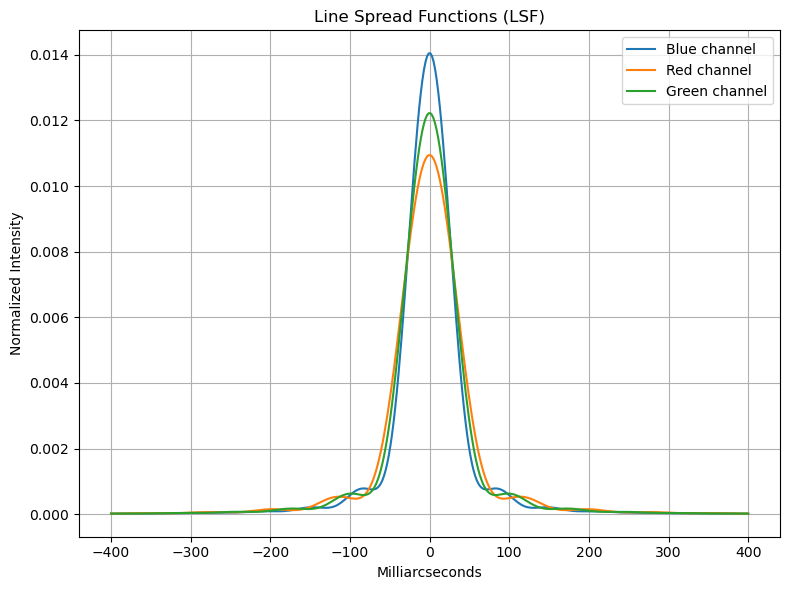

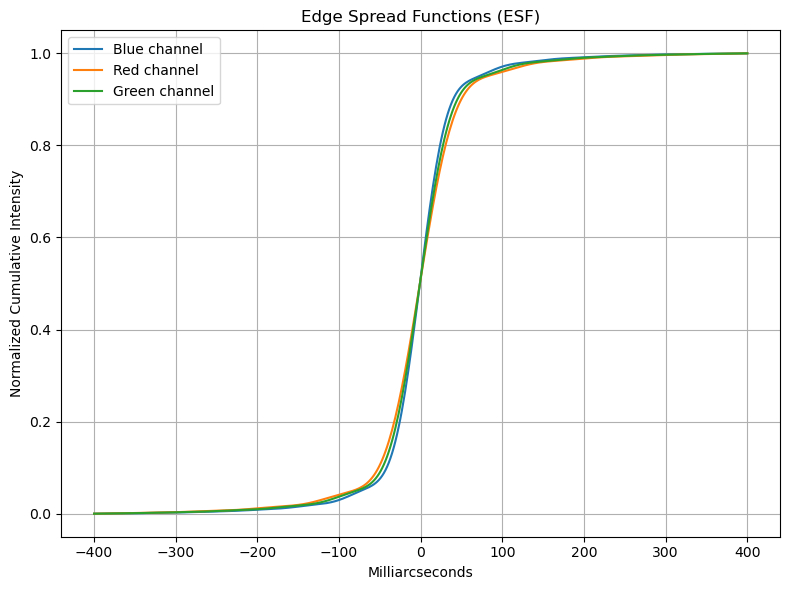

In [53]:
import poppy
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Calibration data and helper functions
# --------------------------

global_CHLfit = np.array([
    [400, 233],
    [410, 151],
    [420, 88],
    [430, 40],
    [440, 4],
    [450, -21],
    [460, -40],
    [470, -52],
    [480, -59],
    [490, -63],
    [500, -63],
    [510, -63],
    [520, -61],
    [530, -57],
    [540, -51],
    [550, -44],
    [560, -35],
    [570, -26],
    [580, -15],
    [590, -4],
    [600, 7],
    [610, 20],
    [620, 33],
    [630, 47],
    [640, 60],
    [650, 74],
    [660, 88],
    [670, 102],
    [680, 116],
    [690, 131],
    [700, 146]
])

def compute_defocus_coefficient_from_calibration(wavelength_m, calibration_array):
    wavelength_nm = wavelength_m * 1e9
    indices = np.where(calibration_array[:, 0] == wavelength_nm)[0]
    if indices.size == 0:
        raise ValueError(f"Wavelength {wavelength_nm} nm not found in calibration data.")
    defocus_value_nm = calibration_array[indices[0], 1]
    defocus_value_m = defocus_value_nm * 1e-9
    # POPPY normalization: 1 unit corresponds to 2*sqrt(3) times the wavefront error (PV)
    return defocus_value_m / (2 * np.sqrt(3))

# --------------------------
# Define optical system parameters.
# --------------------------
xrange_val = 400               # Example value.
RADIUS = xrange_val / 500      # Aperture radius in meters.
PIXSCALE = 0.004               # Detector pixel scale in arcsec/pixel.
FOV = RADIUS                   # Field of view in arcsec (example value).

# Central operating wavelength (for calculating defocus, in meters)
WAVELENGTH = 500e-9  # 500 nm

# Compute defocus coefficient using central wavelength calibration.
defocus_coefficient = compute_defocus_coefficient_from_calibration(WAVELENGTH, global_CHLfit)
# Here the fourth element represents defocus (first three are zeros)
coefficients_sequence = [0, 0, 0, defocus_coefficient]

# Build the optical system using POPPY.
osys = poppy.OpticalSystem()
circular_aperture = poppy.CircularAperture(radius=RADIUS)
osys.add_pupil(circular_aperture)
zernikewfe = poppy.ZernikeWFE(radius=RADIUS, coefficients=coefficients_sequence)
osys.add_pupil(zernikewfe)
osys.add_detector(pixelscale=PIXSCALE, fov_arcsec=FOV)

# --------------------------
# Sensor spectral responses (wavelength in nm, normalized weight)
# --------------------------
SensorBlue_norm = np.array([
    [400, 1.65616401e-06],
    [410, 3.58046885e-05],
    [420, 9.59786474e-05],
    [430, 1.11869935e-04],
    [440, 1.58203095e-04],
    [450, 1.53826090e-04],
    [460, 1.85805829e-04],
    [470, 1.83952502e-04],
    [480, 1.62225208e-04],
    [490, 1.05403009e-04],
    [500, 5.81629026e-05],
    [510, 2.97715196e-05],
    [520, 1.08833635e-05],
    [530, 0.00000000e+00],
    [540, 0.00000000e+00],
    [550, 0.00000000e+00],
    [560, 0.00000000e+00],
    [570, 0.00000000e+00],
    [580, 0.00000000e+00],
    [590, 0.00000000e+00],
    [600, 0.00000000e+00],
    [610, 0.00000000e+00],
    [620, 0.00000000e+00],
    [630, 0.00000000e+00],
    [640, 0.00000000e+00],
    [650, 0.00000000e+00],
    [660, 2.72084087e-06],
    [670, 3.31232801e-06],
    [680, 1.26183924e-06],
    [690, 1.57729905e-07],
    [700, 0.00000000e+00]
])

SensorRed_norm = np.array([
    [400, 0.00000000e+00],
    [410, 3.14144989e-06],
    [420, 4.49468984e-06],
    [430, 5.24380481e-06],
    [440, 4.18054485e-06],
    [450, 0.00000000e+00],
    [460, 0.00000000e+00],
    [470, 0.00000000e+00],
    [480, 0.00000000e+00],
    [490, 0.00000000e+00],
    [500, 0.00000000e+00],
    [510, 0.00000000e+00],
    [520, 0.00000000e+00],
    [530, 0.00000000e+00],
    [540, 0.00000000e+00],
    [550, 0.00000000e+00],
    [560, 0.00000000e+00],
    [570, 5.75126979e-06],
    [580, 1.45424965e-04],
    [590, 2.41649991e-04],
    [600, 2.24082037e-04],
    [610, 1.75800369e-04],
    [620, 1.22274896e-04],
    [630, 8.65348619e-05],
    [640, 8.47708170e-05],
    [650, 5.41295981e-05],
    [660, 4.09838385e-05],
    [670, 1.87278743e-05],
    [680, 7.97444972e-06],
    [690, 1.88486993e-06],
    [700, 4.34969984e-07]
])

SensorGreen_norm = np.array([
    [400, 0.00000000e+00],
    [410, 0.00000000e+00],
    [420, 0.00000000e+00],
    [430, 0.00000000e+00],
    [440, 0.00000000e+00],
    [450, 0.00000000e+00],
    [460, 0.00000000e+00],
    [470, 1.93839922e-05],
    [480, 2.71292158e-05],
    [490, 3.80562610e-05],
    [500, 7.43122809e-05],
    [510, 1.18857783e-04],
    [520, 1.58253759e-04],
    [530, 1.60723857e-04],
    [540, 1.46614990e-04],
    [550, 1.20699891e-04],
    [560, 1.17643667e-04],
    [570, 7.96292723e-05],
    [580, 5.48445566e-05],
    [590, 2.91387873e-05],
    [600, 1.81280099e-05],
    [610, 1.39832686e-05],
    [620, 1.26435543e-05],
    [630, 0.00000000e+00],
    [640, 0.00000000e+00],
    [650, 0.00000000e+00],
    [660, 2.88875909e-06],
    [670, 2.93062516e-06],
    [680, 1.42344651e-06],
    [690, 2.09330369e-07],
    [700, 0.00000000e+00]
])

# --------------------------
# Function to compute integrated (polychromatic) PSF for one sensor channel.
# --------------------------
def compute_channel_psf(sensor_array, osys):
    # Extract wavelengths (m) and weights from the sensor array.
    wavelengths = sensor_array[:, 0] * 1e-9  # convert from nm to meters
    weights = sensor_array[:, 1]
    # Normalize the weights (avoid division by zero)
    if np.sum(weights) > 0:
        weights = weights / np.sum(weights)
    else:
        raise ValueError("The sensor weights sum to zero. Check the spectral data.")
    
    # Initialize the integrated PSF.
    integrated_psf = None
    
    # Loop over each wavelength and accumulate the weighted PSF.
    for wl, weight in zip(wavelengths, weights):
        # Compute the PSF for this wavelength without displaying intermediate steps.
        psf_result = osys.calc_psf(wavelength=wl, display_intermediates=False)
        psf_data = psf_result[0].data.astype(np.float64)
        if integrated_psf is None:
            integrated_psf = weight * psf_data
        else:
            integrated_psf += weight * psf_data
    return integrated_psf

# --------------------------
# Functions to compute LSF and ESF from a PSF
# --------------------------
def calculate_lsf(psf_data, fov_arcsec=1.0):
    ncols = psf_data.shape[1]
    # x-axis in milliarcseconds
    x_detector = np.linspace(-fov_arcsec/2 * 1e3, fov_arcsec/2 * 1e3, ncols)
    lsf = np.sum(psf_data, axis=0)
    # Normalize the LSF such that the area under it equals 1.
    lsf = lsf / np.trapezoid(lsf, x_detector)
    return x_detector, lsf

def calculate_esf(lsf):
    esf = np.cumsum(lsf)
    esf = (esf - esf[0]) / (esf[-1] - esf[0])
    return esf

# --------------------------
# Compute PSF, LSF, and ESF for each sensor channel.
# --------------------------
# Blue channel:
psf_blue = compute_channel_psf(SensorBlue_norm, osys)
x_blue, lsf_blue = calculate_lsf(psf_blue, fov_arcsec=FOV)
esf_blue = calculate_esf(lsf_blue)

# Red channel:
psf_red = compute_channel_psf(SensorRed_norm, osys)
x_red, lsf_red = calculate_lsf(psf_red, fov_arcsec=FOV)
esf_red = calculate_esf(lsf_red)

# Green channel:
psf_green = compute_channel_psf(SensorGreen_norm, osys)
x_green, lsf_green = calculate_lsf(psf_green, fov_arcsec=FOV)
esf_green = calculate_esf(lsf_green)

# --------------------------
# Plotting functions for LSF and ESF curves from all channels
# --------------------------
def plot_multichannel_lsf(x_vals, lsfs, labels):
    plt.figure(figsize=(8, 6))
    for x, lsf, label in zip(x_vals, lsfs, labels):
        plt.plot(x, lsf, label=label)
    plt.xlabel('Milliarcseconds')
    plt.ylabel('Normalized Intensity')
    plt.title('Line Spread Functions (LSF)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_multichannel_esf(x_vals, esfs, labels):
    plt.figure(figsize=(8, 6))
    for x, esf, label in zip(x_vals, esfs, labels):
        plt.plot(x, esf, label=label)
    plt.xlabel('Milliarcseconds')
    plt.ylabel('Normalized Cumulative Intensity')
    plt.title('Edge Spread Functions (ESF)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --------------------------
# Plot the results: both LSF and ESF in separate figures with three channels each.
# --------------------------
# Here, we assume that x_detector is nearly the same for all channels.
x_list = [x_blue, x_red, x_green]
lsf_list = [lsf_blue, lsf_red, lsf_green]
esf_list = [esf_blue, esf_red, esf_green]
labels = ['Blue channel', 'Red channel', 'Green channel']

plot_multichannel_lsf(x_list, lsf_list, labels)
plot_multichannel_esf(x_list, esf_list, labels)
